# Introdu√ß√£o a Modula√ß√£o Digital com √Åudio

‚ö†Ô∏è Esse codigo n√£o funciona em maquinas virtuais ou no WSL


Sobre esse Laborat√≥rio:

- [Setup](#setup)
- [Parametros e Bibliotecas](#parametros-de-configura√ß√µes)
- [Fun√ß√µes e Metodos](#fun√ß√µes)
- [O Laborat√≥rio](#o-laborat√≥rio)
    1. [Etapa 1: Compreendendo com a Codifica√ß√£o/Modula√ß√£o de dados](#etapa-1-compreendendo-com-a-codifica√ß√£omodula√ß√£o-de-dados)
    1. [Etapa 2: Decodifica√ß√£o](#etapa-2-decodifica√ß√£o)
    1. [Etapa 3: Impacto do Ru√≠do na Comunica√ß√£o](#etapa-3-impacto-do-ru√≠do-na-comunica√ß√£o)
    1. [Etapa 4: Decodifica√ß√£o no mundo real](#etapa-4-decodifica√ß√£o-no-mundo-real)



## Setup

‚ö†Ô∏è **Aten√ß√£o** : Execute o c√≥digo abaixo **apenas uma vez** para realizar a configura√ß√£o inicial do ambiente.

In [40]:
!pip install numpy matplotlib soundfile sounddevice scipy

Defaulting to user installation because normal site-packages is not writeable


escolhendo a saida e entrada de audio

In [41]:
import os

import sounddevice as sd
import numpy as np
from scipy.io import wavfile

O comando `sd.query_devices()` listar√° todas as **entradas** e **sa√≠das** de √°udio dispon√≠veis no seu computador. 

A partir dessa lista, identifique qual √© a sua **entrada** (microfone) e **sa√≠da** (alto-falante) de √°udio desejada e atribua esses valores √†s vari√°veis `input_device` e `output_device`, respectivamente. Por exemplo,

```
   5 LG ULTRAWIDE (HD Audio Driver f, MME (0 in, 2 out)
   6 Alto-falantes (3- Realtek(R) Au, MME (0 in, 2 out)
>  7 Driver de captura de som prim√°rio, Windows DirectSound (2 in, 0 out)
   8 Grupo de microfones (3- Tecnologia Intel¬Æ Smart Sound para microfones digitais), Windows DirectSound (2 in, 0 out)
   9 Headset (QCY MeloBuds Pro), Windows DirectSound (1 in, 0 out)
< 10 Driver de som prim√°rio, Windows DirectSound (0 in, 2 out)
  11 Fones de ouvido (QCY MeloBuds Pro), Windows DirectSound (0 in, 8 out)
  12 LG ULTRAWIDE (HD Audio Driver for Display Audio), Windows DirectSound (0 in, 2 out)
```

Para que o laboratorio funcione adequamente no meu computador devo escolher opcoes 7 , 10.

In [42]:
sd.query_devices()

  0 HDA ATI HDMI: 0 (hw:0,3), ALSA (0 in, 2 out)
  1 HDA ATI HDMI: 1 (hw:0,7), ALSA (0 in, 8 out)
  2 HDA ATI HDMI: 2 (hw:0,8), ALSA (0 in, 8 out)
< 3 HDA ATI HDMI: 3 (hw:0,9), ALSA (0 in, 2 out)
> 4 FHD Camera Microphone: USB Audio (hw:1,0), ALSA (2 in, 0 out)
  5 HD-Audio Generic: ALC897 Analog (hw:2,0), ALSA (2 in, 2 out)
  6 HD-Audio Generic: ALC897 Alt Analog (hw:2,2), ALSA (2 in, 0 out)
  7 hdmi, ALSA (0 in, 2 out)
  8 pulse, ALSA (32 in, 32 out)
  9 default, ALSA (32 in, 32 out)

In [43]:
output_device = 3
input_device = 4
sd.default.device = (input_device, output_device)

üéØ Execute o c√≥digo abaixo para gravar um √°udio de 3 segundos e, em seguida, reproduzi-lo.

Caso a grava√ß√£o ou reprodu√ß√£o n√£o funcione corretamente, ajuste os valores das vari√°veis `input_device` (dispositivo de entrada) e `output_device` (dispositivo de sa√≠da) at√© que o c√≥digo funcione como esperado.

In [44]:
DURATION = 3  # dura√ßao em segundos
SAMPLE_RATE = 44100  # Hz
FILENAME = "captura.wav"

audio = sd.rec(int(DURATION * SAMPLE_RATE), samplerate=SAMPLE_RATE, channels=1, dtype='float32')
sd.wait()
print("Grava√ß√£o finalizada.")

# Salvando arquivo de audio temporario
max_val = np.max(np.abs(audio))
if max_val > 0:
    scaled = audio / max_val
else:
    scaled = audio
wav_data = np.int16(scaled * 32767)
wavfile.write(FILENAME, SAMPLE_RATE, wav_data)
print(f"√Åudio salvo em {FILENAME}")

# Reproduz o √°udio salvo
fs, data = wavfile.read(FILENAME)
sd.play(data, fs)
sd.wait()
os.remove(FILENAME)
print('Se voc√™ escutou o audio tudo seu sistema est√° configurado corretamente!')

Grava√ß√£o finalizada.
√Åudio salvo em captura.wav
Se voc√™ escutou o audio tudo seu sistema est√° configurado corretamente!


## Parametros de configura√ß√µes

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import sounddevice as sd
from scipy import signal
import time

parametros de codifica√ß√£o

In [46]:
##
## configuracoes do audio (detalhes na sec√ß√£o de setup)
##

# output_device = 10
# input_device = 7
output_device = 3
input_device = 4
sd.default.device = (input_device, output_device)

##
## Configura√ß√µes globais do exercio
##
SAMPLE_RATE = 44100  # Taxa de amostragem do audio
BIT_DURATION = 1.0   # 1 segundo por bit
FREQ_LOW = 440       # bit '0' (L√°)
FREQ_HIGH = 880      # bit '1' (L√° oitava)

## Fun√ß√µes

Nessa secao voc√™s encontraram as funcoes utilizadas

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import sounddevice as sd
from scipy import signal
import time

### Gerador de tom & visualizacao

In [48]:
def generate_tone(frequency, duration, sample_rate=SAMPLE_RATE):
    """
    Gera um tom senoidal
    
    Args:
        frequency: Frequ√™ncia em Hz
        duration: Dura√ß√£o em segundos
        sample_rate: Taxa de amostragem
    
    Returns:
        array: Sinal de √°udio
    """
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    # Aplica janela para suavizar transi√ß√µes
    tone = np.sin(2 * np.pi * frequency * t)
    # Janela de Hanning para evitar cliques
    window = np.hanning(len(tone))
    return tone * window

In [49]:
def show(data:str,debug):
    if debug==True:
        print(data)

In [50]:
def plot_signal(audio_signal, title, num_bits):
    time_axis = np.linspace(0, len(audio_signal)/SAMPLE_RATE, len(audio_signal))
    
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, audio_signal)
    plt.title(title)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    for i in range(1, num_bits): #divis√µes dos bits
        plt.axvline(x=i*BIT_DURATION, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

### Codificadores

In [51]:
def encode_nrz(data_bits,debug=False):
    """
    Codifica dados usando NRZ
    
    Args:
        data_bits: string de bits (ex: "10110")
    
    Returns:
        array: Sinal de √°udio codificado
    """
    audio_signal = np.array([])
    
    show(f"Codificando NRZ: {data_bits}",debug)
    
    for i, bit in enumerate(data_bits):
        if bit == '1':
            freq = FREQ_HIGH
            show(f"Bit {i}: '1' -> {freq} Hz",debug)
        else:
            freq = FREQ_LOW
            show(f"Bit {i}: '0' -> {freq} Hz",debug)
        
        tone = generate_tone(freq, BIT_DURATION)
        audio_signal = np.concatenate([audio_signal, tone])
    
    return audio_signal

In [52]:
def encode_nrzi(data_bits,debug=False):
    """
    Codifica dados usando NRZI
    
    Args:
        data_bits: string de bits
    
    Returns:
        array: Sinal de √°udio codificado
    """
    pass
    
    return '0'

In [53]:
def encode_manchester(data_bits,debug=False):
    """
    Codifica dados usando Manchester
    
    Args:
        data_bits: string de bits
    
    Returns:
        array: Sinal de √°udio codificado
    """
    audio_signal = np.array([])
    
    show(f"Codificando Manchester: {data_bits}",debug)
    
    for i, bit in enumerate(data_bits):
        if bit == '1':
            # Bit '1': alto->baixo (primeira metade alta, segunda baixa)
            tone1 = generate_tone(FREQ_HIGH, BIT_DURATION/2)
            tone2 = generate_tone(FREQ_LOW, BIT_DURATION/2)
            show(f"Bit {i}: '1' -> {FREQ_HIGH}Hz -> {FREQ_LOW}Hz",debug)
        else:
            # Bit '0': baixo->alto (primeira metade baixa, segunda alta)
            tone1 = generate_tone(FREQ_LOW, BIT_DURATION/2)
            tone2 = generate_tone(FREQ_HIGH, BIT_DURATION/2)
            show(f"Bit {i}: '0' -> {FREQ_LOW}Hz -> {FREQ_HIGH}Hz",debug)
        
        bit_signal = np.concatenate([tone1, tone2])
        audio_signal = np.concatenate([audio_signal, bit_signal])
    
    return audio_signal

### Decodificadores

#### Detector de frequ√™ncia

Neste trecho de c√≥digo, vamos utilizar a **Transformada R√°pida de Fourier (FFT)** para detectar frequ√™ncias dominantes em segmentos de √°udio ‚Äî uma ferramenta para an√°lise espectral de sinais. Utilizamos esse conceito em sala de aula para ilustrar o conceito de **modula√ß√£o por divis√£o de frequ√™ncia (FDM)**. Esse codigos detectaram os bits `0` e `1` em raz√£o das fequ√™ncias que estabelessemos. 

A fun√ß√£o `detect_frequency` tem como objetivo identificar as frequ√™ncias que comp√µem um sinal de √°udio modulado. Na Figura 1, vemos duas senoides (uma azul e uma vermelha), representando frequ√™ncias distintas associadas aos bits `'0'` e `'1'`. Essas senoides s√£o combinadas para formar o sinal apresentado na Figura 2, o qual ser√° analisado.


| Figura 1 | Figura 2 | 
| :-:   | :-: |
| 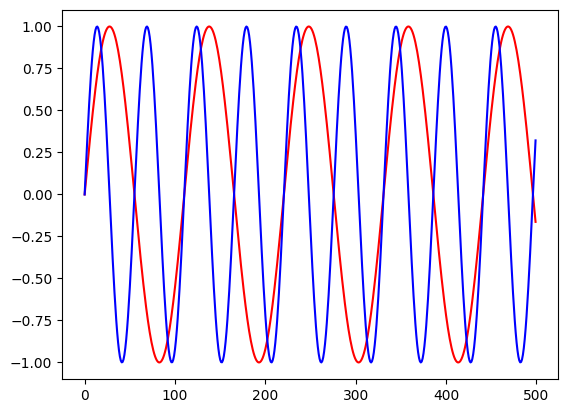 | 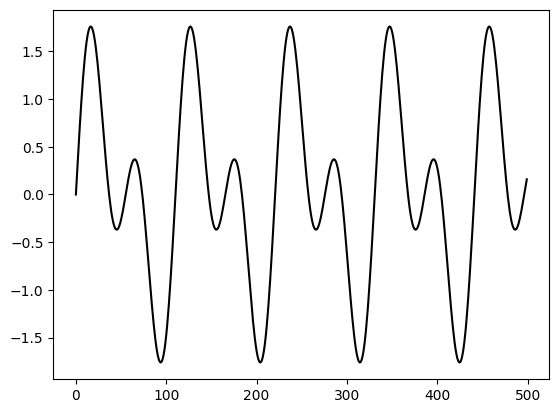 |

O c√≥digo utiliza a FFT para detectar os picos de frequ√™ncia presentes no sinal composto. Esses picos ‚Äî vis√≠veis no gr√°fico espectral gerado pela FFT (Figura 3) ‚Äî correspondem exatamente √†s componentes originais da modula√ß√£o, permitindo que cada segmento de √°udio seja interpretado como `'0'` ou `'1'` com base em qual frequ√™ncia est√° presente.

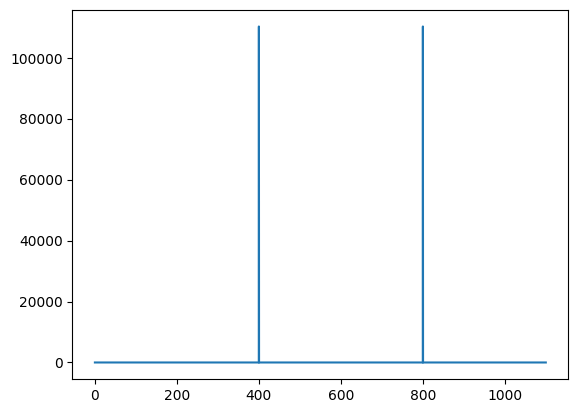

Assim como vimos em sala de aula, essa abordagem ilustra o processo de demodula√ß√£o por frequ√™ncia, fundamental no modelo de transmiss√£o FDM (Frequency Division Multiplexing).

J√° a fun√ß√£o `frequency_to_bit` interpreta a frequ√™ncia detectada como um bit bin√°rio, comparando-a com um limiar: se for superior ao valor definido, retorna `'1'`; caso contr√°rio, `'0'`. Esse processo simula uma decodifica√ß√£o simples de sinais FDM com base na presen√ßa de faixas de frequ√™ncia distintas.


üîß **Observa√ß√£o**: valores como `SAMPLE_RATE` e o `threshold` devem estar de acordo com as frequ√™ncias utilizadas (ja configurados no inicio do notebook) durante a modula√ß√£o para garantir a correta detec√ß√£o dos dados transmitidos.

In [54]:
def detect_frequency(audio_segment, sample_rate=SAMPLE_RATE):
    """
    Detecta a frequ√™ncia dominante em um segmento de √°udio
    
    Args:
        audio_segment: Segmento de √°udio
        sample_rate: Taxa de amostragem
    
    Returns:
        float: Frequ√™ncia detectada
    """
    # FFT para an√°lise espectral
    fft = np.fft.fft(audio_segment)
    freqs = np.fft.fftfreq(len(fft), 1/sample_rate)
    
    # Considera apenas frequ√™ncias positivas
    magnitude = np.abs(fft[:len(fft)//2])
    freqs_positive = freqs[:len(freqs)//2]
    
    # Encontra o pico de frequ√™ncia
    peak_idx = np.argmax(magnitude)
    detected_freq = abs(freqs_positive[peak_idx])
    
    return detected_freq

def frequency_to_bit(frequency, threshold=660):
    """
    Converte frequ√™ncia detectada em bit
    
    Args:
        frequency: Frequ√™ncia detectada
        threshold: Limiar para decis√£o (m√©dia entre FREQ_LOW e FREQ_HIGH)
    
    Returns:
        str: '0' ou '1'
    """
    return '1' if frequency > threshold else '0'

#### Decoders

In [55]:
def decode_nrz(audio_signal, num_bits, sample_rate=SAMPLE_RATE,debug=False):
    """
    Decodifica sinal NRZ
    
    Args:
        audio_signal: Sinal de √°udio
        num_bits: N√∫mero esperado de bits
        sample_rate: Taxa de amostragem
    
    Returns:
        str: Bits decodificados
    """
    samples_per_bit = int(sample_rate * BIT_DURATION)
    decoded_bits = ""
    
    show("Decodificando NRZ:",debug)
    
    for i in range(num_bits):
        start_idx = i * samples_per_bit
        end_idx = start_idx + samples_per_bit
        
        if end_idx > len(audio_signal):
            show(f"Aviso: √Åudio muito curto para {num_bits} bits",debug)
            break
        
        # Analisa o meio do bit para evitar transi√ß√µes
        mid_start = start_idx + samples_per_bit // 4
        mid_end = end_idx - samples_per_bit // 4
        segment = audio_signal[mid_start:mid_end]
        
        freq = detect_frequency(segment, sample_rate)
        bit = frequency_to_bit(freq)
        decoded_bits += bit
        
        show(f"Bit {i}: freq={freq:.1f}Hz -> '{bit}'",debug)
    
    return decoded_bits

In [56]:
def decode_nrzi(audio_signal, num_bits, sample_rate=SAMPLE_RATE,debug=False):
    """
    Decodifica sinal NRZI
    """

    pass
    
    return '0'

In [57]:
def decode_manchester(audio_signal, num_bits, sample_rate=SAMPLE_RATE,debug=False):
    """
    Decodifica sinal Manchester
    """
    samples_per_bit = int(sample_rate * BIT_DURATION)
    decoded_bits = ""
    
    show("Decodificando Manchester:",debug)
    
    for i in range(num_bits):
        start_idx = i * samples_per_bit
        end_idx = start_idx + samples_per_bit
        
        if end_idx > len(audio_signal):
            break
        
        # Analisa primeira e segunda metade do bit
        mid_point = start_idx + samples_per_bit // 2
        
        # Primeira metade
        first_half = audio_signal[start_idx + samples_per_bit//8 : mid_point - samples_per_bit//8]
        freq1 = detect_frequency(first_half, sample_rate)
        state1 = frequency_to_bit(freq1)
        
        # Segunda metade
        second_half = audio_signal[mid_point + samples_per_bit//8 : end_idx - samples_per_bit//8]
        freq2 = detect_frequency(second_half, sample_rate)
        state2 = frequency_to_bit(freq2)
        
        # Determina o bit baseado na transi√ß√£o
        if state1 == '1' and state2 == '0': # Alto -> Baixo
            bit = '1'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = alto->baixo = '1'",debug)
        elif state1 == '0' and state2 == '1': # Baixo -> Alto
            bit = '0'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = baixo->alto = '0'",debug)
        else: # Erro de decodifica√ß√£o
            bit = '?'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = ERRO na transi√ß√£o",debug)
        
        decoded_bits += bit
    
    return decoded_bits

## O Laborat√≥rio

In [58]:
##
## configuracoes do audio (detalhes na sec√ß√£o de setup)
##
# output_device = 10
# input_device = 7
output_device = 3
input_device = 4
sd.default.device = (input_device, output_device)

##
## Configura√ß√µes globais do exercio
##
SAMPLE_RATE = 44100  # Taxa de amostragem do audio
BIT_DURATION = 1.0   # 1 segundo por bit
FREQ_LOW = 440       # bit '0' (L√°)
FREQ_HIGH = 880      # bit '1' (L√° oitava)

### Etapa 1: Compreendendo com a Codifica√ß√£o/Modula√ß√£o de dados

Nessa se√ß√£o voc√™ deve se familiariazar com algumas das funa√ß√µes de codifica√ß√£o (modula√ß√£o) vista em sala de aula

In [59]:
test_bits = "11001"
print(f"Dados originais: {test_bits}\n")

Dados originais: 11001



In [60]:
# Testa cada modula√ß√£o
print("1. NRZ:")
nrz_signal = encode_nrz(test_bits,debug=True)

print("\n3. Manchester:")
manchester_signal = encode_manchester(test_bits,debug=True)

1. NRZ:
Codificando NRZ: 11001
Bit 0: '1' -> 880 Hz
Bit 1: '1' -> 880 Hz
Bit 2: '0' -> 440 Hz
Bit 3: '0' -> 440 Hz
Bit 4: '1' -> 880 Hz

3. Manchester:
Codificando Manchester: 11001
Bit 0: '1' -> 880Hz -> 440Hz
Bit 1: '1' -> 880Hz -> 440Hz
Bit 2: '0' -> 440Hz -> 880Hz
Bit 3: '0' -> 440Hz -> 880Hz
Bit 4: '1' -> 880Hz -> 440Hz


**Escutando os dados** como a nossa proposta √© utilizar notas m√∫sicais (som) para representar `0` e `1`. Vamos escutalos.

In [61]:
sd.play(manchester_signal, SAMPLE_RATE)
sd.wait()

In [62]:
sd.play(nrz_signal, SAMPLE_RATE)
sd.wait()

Voc√™ pode visualizar a modula√ß√£o utilizando plots, com abaixo

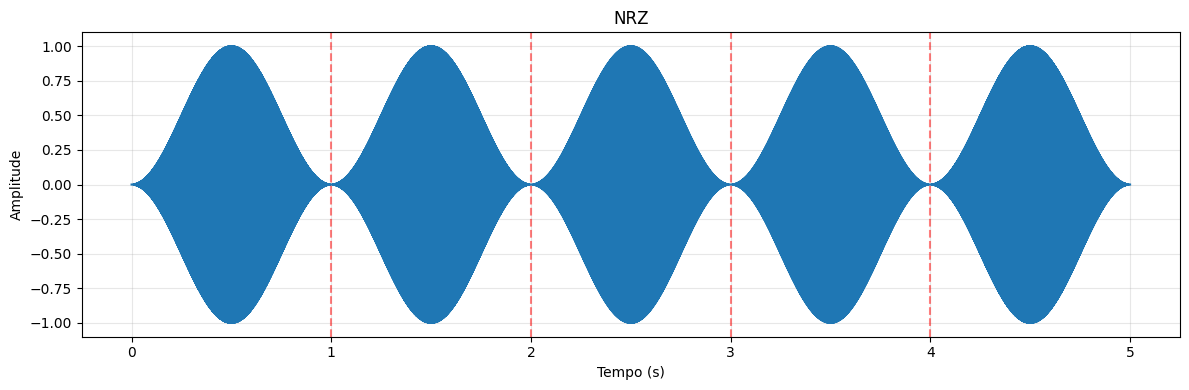

In [63]:
plot_signal(nrz_signal,'NRZ',len(test_bits))

##### Esse modula√ß√£o foi utilizada nos prim√≥rdios da internet (internet discada)

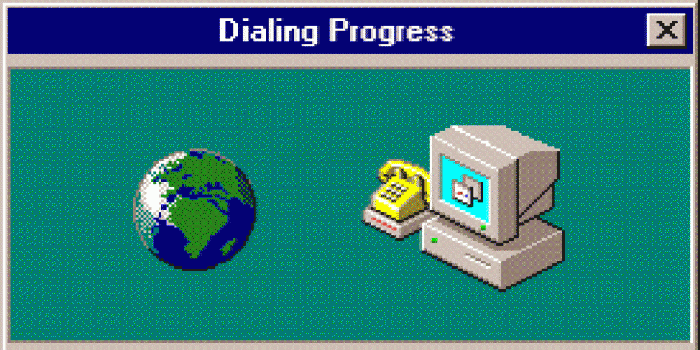

A internet discada utilizava modula√ß√£o anal√≥gica para transportar dados digitais pela linha telef√¥nica. Nos primeiros modems ‚Äî como os que seguiram o padr√£o Bell 103 ‚Äî a t√©cnica predominante foi a Frequency Shift Keying (FSK), onde duas frequ√™ncias distintas (uma para o bit 0 e outra para o bit 1) eram usadas para representar os dados.

Para quem n√£o teve a oportunidade de utilizar a internet discada o video abaixo ilustra bem o processo de modula√ß√£o utilizada

<iframe width="560" height="315" src="https://www.youtube.com/embed/ofVEEWObx_I?si=VzAD8hgPPeyXFSRn" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

### Etapa 2: Decodifica√ß√£o

Nesta etapa voc√™s ir√£o  recuperar os dados originais a partir do sinal de √°udio recebido. Este √© o papel do receptor em um sistema de comunica√ß√£o.

O promeiro passo para a decodifica√ß√£o (demodula√ß√£o) em um mundo ideal √© salvar o resultado da modula√ß√£o em um arquivo de audio (.wav)

In [64]:
# Dados de teste
test_data = "1010100000001111110000010101010111000"

print(f"Criando arquivos de teste para: {test_data}")

# NRZ
nrz_signal = encode_nrz(test_data)
sf.write('teste_nrz.wav', nrz_signal, SAMPLE_RATE)
print("\t ‚úì Arquivo teste_nrz.wav criado")

# Manchester
manchester_signal = encode_manchester(test_data)
sf.write('teste_manchester.wav', manchester_signal, SAMPLE_RATE)
print("\t ‚úì Arquivo teste_manchester.wav criado")


Criando arquivos de teste para: 1010100000001111110000010101010111000
	 ‚úì Arquivo teste_nrz.wav criado
	 ‚úì Arquivo teste_manchester.wav criado


In [65]:
original_data = test_data

print(f"\nDados originais: {original_data}")
print(f"N√∫mero de bits: {len(original_data)}\n")


Dados originais: 1010100000001111110000010101010111000
N√∫mero de bits: 37



Para evitar efeitos de atenua√ß√£o e interferencias vamos realizar a decodifica√ß√£o diretamente do arquivo de audio.

In [66]:
# Testa decodifica√ß√£o NRZ
print("1. Decodificando NRZ:")
nrz_audio, _ = sf.read('teste_nrz.wav')
decoded_nrz = decode_nrz(nrz_audio, len(original_data))
print(f"Original: {original_data}")
print(f"Decodificado: {decoded_nrz}")
print(f"Correto: {original_data == decoded_nrz}\n")

1. Decodificando NRZ:
Original: 1010100000001111110000010101010111000
Decodificado: 1010100000001111110000010101010111000
Correto: True



In [67]:
# Testa decodifica√ß√£o Manchester
print("3. Decodificando Manchester:")
manchester_audio, _ = sf.read('teste_manchester.wav')
decoded_manchester = decode_manchester(manchester_audio, len(original_data))
print(f"Original: {original_data}")
print(f"Decodificado: {decoded_manchester}")
print(f"Correto: {original_data == decoded_manchester}")

3. Decodificando Manchester:
Original: 1010100000001111110000010101010111000
Decodificado: 1010100000001111110000010101010111000
Correto: True


### Etapa 3: Impacto do Ru√≠do na Comunica√ß√£o

Simula√ß√£o de decodifica√ß√£o em condi√ß√µes adversas, o metodo abaixo simula a adi√ß√£o de ru√≠do ao sinal.

In [68]:
def adicionar_ruido(audio_signal, snr_db=-12):
    """
    Adiciona ru√≠do gaussiano ao sinal
    
    Args:
        audio_signal: Sinal original
        snr_db: Rela√ß√£o sinal-ru√≠do em dB
    
    Returns:
        array: Sinal com ru√≠do
    """
    # Calcula pot√™ncia do sinal
    signal_power = np.mean(audio_signal ** 2)
    
    # Calcula pot√™ncia do ru√≠do baseada no SNR
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    
    # Gera ru√≠do gaussiano
    noise = np.random.normal(0, np.sqrt(noise_power), len(audio_signal))
    
    return audio_signal + noise

Para adicionar ruido utilize um valor **negativo** no `snr_db`. Por exemplo se voc√™ quiser um ruido de 3db utilize `snr_db=-3` no metodo.

A baixo veja a menssagem original

In [69]:
original_bits = "00111000"

In [70]:
snr=-3

clean_signal = encode_nrz(original_bits)

noisy_signal = adicionar_ruido(clean_signal, snr)
decoded = decode_nrz(noisy_signal, len(original_bits))
print(f"  Original: {original_bits}")
print(f"  Decodificado: {decoded}")
print(f"  Correto: {original_bits == decoded}\n")

  Original: 00111000
  Decodificado: 00111000
  Correto: True



### Etapa 4: Decodifica√ß√£o no mundo real

In [81]:
def capturar_do_microfone(duracao_segundos):
    """
    Captura √°udio do microfone
    
    Args:
        duracao_segundos: Dura√ß√£o da captura
    
    Returns:
        array: √Åudio capturado
    """
    print(f"Iniciando captura por {duracao_segundos} segundos...")
    print("Reproduza o √°udio no seu celular AGORA!")
    
    # Captura √°udio
    audio_capturado = sd.rec(
        int(duracao_segundos * SAMPLE_RATE), 
        samplerate=SAMPLE_RATE, 
        channels=1
    )
    sd.wait()  # Aguarda terminar a captura
    
    print("Captura conclu√≠da!")
    return audio_capturado.flatten()

In [82]:
import random
import csv


def gerar_string_binaria(n):
    return ''.join(random.choice('01') for _ in range(n))


def gerar_questao(n,start=8,stop=16):
    dados = []
    for i in range(n):
        n_bits = random.randrange(start,stop)
        msg = gerar_string_binaria(n_bits)
        encoder = random.choice([encode_manchester, encode_nrz])
        modulacao = encoder.__name__
        nome = f"dados_{i}_{SAMPLE_RATE}hz.wav"
        sinal = encoder(msg)
        sf.write(nome, sinal, SAMPLE_RATE)
        
        linha = {
            'arquivo':nome,
            'msg': msg,
            'n_bits':n_bits,
            'modulacao':modulacao
        }
        dados.append(linha)
        # print(n_bits,msg,modulacao,nome,len(sinal))
    # print(dados):
    
    nome_arquivo = 'gabarito.csv'

    # Escrita no arquivo CSV
    with open(nome_arquivo, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=dados[0].keys())
        writer.writeheader()
        writer.writerows(dados)



gerar_questao(50)

Para este exerc√≠cio, voc√™ dever√° utilizar um **segundo dispositivo**, como por exemplo, seu **celular**.

1. Copie o arquivo de √°udio [dados_ar.wav](./dados_ar.wav) para o segundo dispositivo.
2. Este √°udio cont√©m uma **mensagem de 5 bits**, codificada utilizando o esquema **Manchester**.
3. O desafio consiste em **decodificar essa mensagem utilizando apenas o microfone do seu computador**.  
   **N√£o abra o arquivo diretamente** no computador ‚Äî apenas reproduza o √°udio no segundo dispositivo.

> üß™ Certifique-se de que os [procedimentos de configura√ß√£o](#setup) foram seguidos corretamente e que o microfone do seu computador est√° funcionando adequadamente.

Por fim, **execute o c√≥digo abaixo** (referente √† etapa de escuta por microfone) e reproduza o √°udio no segundo dispositivo para tentar decodificar a mensagem.

In [83]:
# test_data = "10110"
# Captura √°udio

duracao = 5 * BIT_DURATION + 1  # +1 segundo de margem
audio_capturado = capturar_do_microfone(duracao)

# Salva captura para an√°lise
sf.write('captura_microfone.wav', audio_capturado, SAMPLE_RATE)

# Tenta decodificar
print("\nTentando decodificar...")
decoded = decode_manchester(audio_capturado, 5)

print(f"Original: ?????")
print(f"Capturado: {decoded}")

Iniciando captura por 6.0 segundos...
Reproduza o √°udio no seu celular AGORA!
Captura conclu√≠da!

Tentando decodificar...
Original: ?????
Capturado: ?????


**Etapa A3.1:**

A partir de que n√≠vel de ru√≠do, para cada modula√ß√£o, o sistema come√ßa a falhar?
- a) Identifique o valor de SNR onde os primeiros bits s√£o comprometidos
- b) Identifique o valor de SNR onde os primeiros todos os bits s√£o comprometidos

In [ ]:
#build setup

original_bits = "00000000"
num_bits = len(original_bits)
num_execucoes = 100
step = 2 

In [84]:
def testar_nrz(bits, snr):
    respostas = []
    erro_total_ocorreu = False
    erro_ocorreu = False
    for _ in range(num_execucoes):
        clean = encode_nrz(bits)
        noisy = adicionar_ruido(clean, snr)
        decoded = decode_nrz(noisy, len(bits))
        erros = sum(b1 != b2 for b1, b2 in zip(bits, decoded))
        if erros > 0:
            erro_ocorreu = True
        if erros == num_bits:
            erro_total_ocorreu = True
        respostas.append(decoded)
    media_erros = np.mean([sum(b1 != b2 for b1, b2 in zip(bits, r)) for r in respostas])
    parar = snr == -40
    return media_erros, parar, erro_ocorreu, erro_total_ocorreu

In [85]:
def testar_manchester(bits, snr):
    respostas = []
    erro_total_ocorreu = False
    erro_ocorreu = False
    for _ in range(num_execucoes):
        clean = encode_manchester(bits)
        noisy = adicionar_ruido(clean, snr)
        decoded = decode_manchester(noisy, len(bits))
        erros = sum(b1 != b2 for b1, b2 in zip(bits, decoded))
        if erros > 0:
            erro_ocorreu = True
        if erros == num_bits:
            erro_total_ocorreu = True
        respostas.append(decoded)
    media_erros = np.mean([sum(b1 != b2 for b1, b2 in zip(bits, r)) for r in respostas])
    parar = snr == -40
    return media_erros, parar, erro_ocorreu, erro_total_ocorreu

In [86]:
def gerar_curva(bits, snr_inicial, testar_fn, nome):
    snrs = []
    medias = []
    snr = snr_inicial
    snr_primeiro_erro = None
    snr_erro_total = None

    while True:
        media, parar, erro_ocorreu, erro_total = testar_fn(bits, snr)
        print(f"{nome} | SNR = {snr} dB: m√©dia de erros = {media:.2f}"
              f"{' [1¬∫ ERRO]' if erro_ocorreu and snr_primeiro_erro is None else ''}"
              f"{' [ERRO TOTAL]' if erro_total and snr_erro_total is None else ''}"
              f"{' [PARAR]' if parar else ''}")

        snrs.append(snr)
        medias.append(media)

        if erro_ocorreu and snr_primeiro_erro is None:
            snr_primeiro_erro = snr
        if erro_total and snr_erro_total is None:
            snr_erro_total = snr
        if parar:
            break
        snr -= step

    return snrs, medias, snr_primeiro_erro, snr_erro_total

In [87]:
def encontrar_primeiro_erro(snrs, erros):
    for snr, erro in zip(snrs, erros):
        if erro > 0:
            return snr
    return None

NRZ | SNR = -28 dB: m√©dia de erros = 0.00
NRZ | SNR = -30 dB: m√©dia de erros = 0.29 [1¬∫ ERRO]
NRZ | SNR = -32 dB: m√©dia de erros = 1.83
NRZ | SNR = -34 dB: m√©dia de erros = 4.93 [ERRO TOTAL]
NRZ | SNR = -36 dB: m√©dia de erros = 6.72
NRZ | SNR = -38 dB: m√©dia de erros = 7.41
NRZ | SNR = -40 dB: m√©dia de erros = 7.67 [PARAR]
Manchester | SNR = -24 dB: m√©dia de erros = 0.00
Manchester | SNR = -26 dB: m√©dia de erros = 0.06 [1¬∫ ERRO]
Manchester | SNR = -28 dB: m√©dia de erros = 0.72
Manchester | SNR = -30 dB: m√©dia de erros = 3.18
Manchester | SNR = -32 dB: m√©dia de erros = 5.67 [ERRO TOTAL]
Manchester | SNR = -34 dB: m√©dia de erros = 6.98
Manchester | SNR = -36 dB: m√©dia de erros = 7.46
Manchester | SNR = -38 dB: m√©dia de erros = 7.61
Manchester | SNR = -40 dB: m√©dia de erros = 7.63 [PARAR]


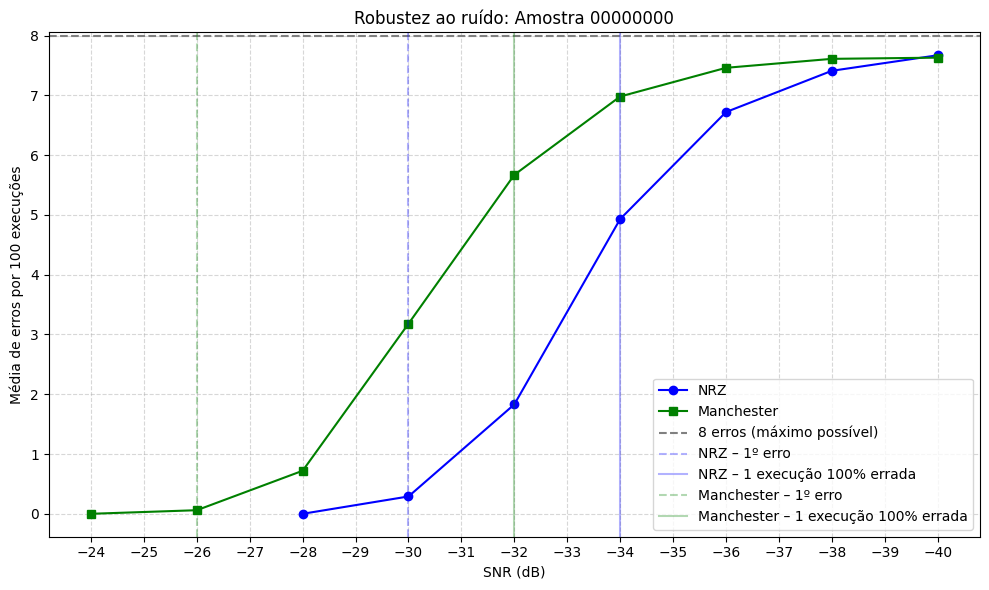

In [ ]:
snrs_nrz, erros_nrz, snr_1_erro_nrz, snr_erro_total_nrz = gerar_curva(original_bits, -28, testar_nrz, "NRZ")
snrs_manchester, erros_manchester, snr_1_erro_man, snr_erro_total_man = gerar_curva(original_bits, -24, testar_manchester, "Manchester")

primeiro_erro_nrz = encontrar_primeiro_erro(snrs_nrz, erros_nrz)
primeiro_erro_man = encontrar_primeiro_erro(snrs_manchester, erros_manchester)

plt.figure(figsize=(10, 6))
plt.plot(snrs_nrz, erros_nrz, 'o-', label='NRZ', color='blue')
plt.plot(snrs_manchester, erros_manchester, 's-', label='Manchester', color='green')
plt.axhline(y=num_bits, color='gray', linestyle='--', label='8 erros (m√°ximo poss√≠vel)')
if snr_1_erro_nrz is not None:
    plt.axvline(snr_1_erro_nrz, linestyle='--', color='blue', alpha=0.3, label='NRZ ‚Äì 1¬∫ erro')

if snr_erro_total_nrz is not None:
    plt.axvline(snr_erro_total_nrz, linestyle='-', color='blue', alpha=0.3, label='NRZ ‚Äì 1 execu√ß√£o 100% errada')

if snr_1_erro_man is not None:
    plt.axvline(snr_1_erro_man, linestyle='--', color='green', alpha=0.3, label='Manchester ‚Äì 1¬∫ erro')

if snr_erro_total_man is not None:
    plt.axvline(snr_erro_total_man, linestyle='-', color='green', alpha=0.3, label='Manchester ‚Äì 1 execu√ß√£o 100% errada')
    
plt.xlabel("SNR (dB)")
plt.ylabel("M√©dia de erros por 100 execu√ß√µes")
plt.title("Robustez ao ru√≠do: Amostra 00000000")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.gca().invert_xaxis()
todos_snrs = snrs_nrz + snrs_manchester
plt.xticks(np.arange(min(todos_snrs), max(todos_snrs) + 1, 1))
plt.tight_layout()
plt.show()

**Exemplo de uma execu√ß√£o:**

NRZ | SNR = -28 dB: m√©dia de erros = 0.00

NRZ | SNR = -30 dB: m√©dia de erros = 0.29 [1¬∫ ERRO]

NRZ | SNR = -32 dB: m√©dia de erros = 1.83

NRZ | SNR = -34 dB: m√©dia de erros = 4.93 [ERRO TOTAL]

NRZ | SNR = -36 dB: m√©dia de erros = 6.72

NRZ | SNR = -38 dB: m√©dia de erros = 7.41

NRZ | SNR = -40 dB: m√©dia de erros = 7.67 [PARAR]

Manchester | SNR = -24 dB: m√©dia de erros = 0.00

Manchester | SNR = -26 dB: m√©dia de erros = 0.06 [1¬∫ ERRO]

Manchester | SNR = -28 dB: m√©dia de erros = 0.72

Manchester | SNR = -30 dB: m√©dia de erros = 3.18

Manchester | SNR = -32 dB: m√©dia de erros = 5.67 [ERRO TOTAL]

Manchester | SNR = -34 dB: m√©dia de erros = 6.98

Manchester | SNR = -36 dB: m√©dia de erros = 7.46

Manchester | SNR = -38 dB: m√©dia de erros = 7.61

Manchester | SNR = -40 dB: m√©dia de erros = 7.63 [PARAR]

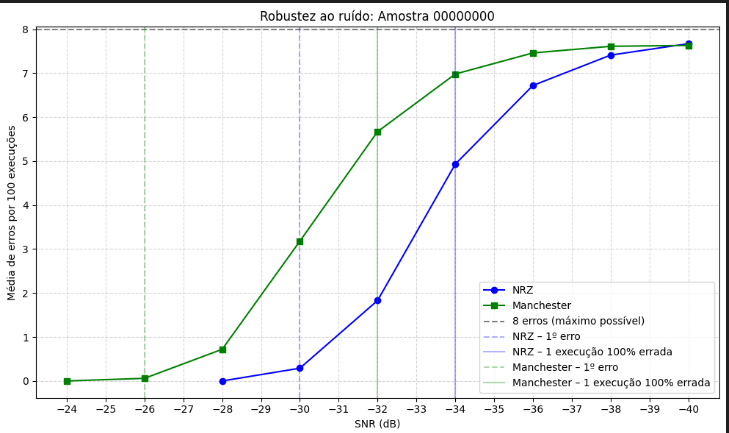

Dado que NRZ demorou mais para apresentar algum erro, nesse cen√°rio de teste ele foi mais robusto ao ru√≠do que o Manchester. NRZ apresentou o primeiro erro em alguma amostra na faixa dos -30 dB e uma amostra com erro total na faixa dos -34 dB, j√° o Manchester apresentou o primeiro erro na faixa dos -26 dB e erro total na faixa dos -32 dB, apesar disso, precisou de uma diferen√ßa de -6 dB do primeiro erro at√© o erro total, enquanto NRZ alcan√ßou o erro total com -4 dB ap√≥s o primeiro erro ocorrer.


**Explica√ß√£o do C√≥digo:**

As fun√ß√µes **testar_nrz** e **testar_manchester** realizam testes em uma sequ√™ncia de bits, aplicando ru√≠do em diferentes n√≠veis de *SNR* (Rela√ß√£o Sinal/Ru√≠do). Para cada n√≠vel de *SNR*, s√£o executados v√°rios ciclos de teste (um n√∫mero predefinido de execu√ß√µes), nos quais a amostra de bits √© corrompida por ru√≠do e decodificada. Durante esse processo, a fun√ß√£o monitora dois eventos: o primeiro erro, ou seja, quando ocorre a primeira discrep√¢ncia entre o bit transmitido e o decodificado, e o erro total, que acontece quando todos os bits da amostra s√£o decodificados incorretamente pela primeira vez.

O intervalo de *SNR* come√ßa com um valor inicial (como -28 dB para *NRZ* e -24 dB para *Manchester*) e √© decrementado em 2 dB a cada execu√ß√£o, at√© atingir -40 dB. Com esses dados, a fun√ß√£o **gerar_curva** coleta os valores de erro m√©dio por execu√ß√£o e registra os pontos de primeiro erro e erro total para cada modula√ß√£o.

Esses valores s√£o ent√£o utilizados para gerar curvas de desempenho, que s√£o plotadas em um gr√°fico utilizando matplotlib. O gr√°fico exibe a rela√ß√£o entre a *SNR* e o n√∫mero m√©dio de erros por execu√ß√£o, destacando o momento em que ocorre o primeiro erro e o erro total para cada tipo de modula√ß√£o (*NRZ* e *Manchester*). Isso nos permite visualizar e comparar a robustez das duas modula√ß√µes frente a diferentes n√≠veis de ru√≠do.

**Link para o reposit√≥rio com a atividade:** https://github.com/ViniciusI4n/redes-atvd1